# Pre-class work recap

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt

%matplotlib inline

### Import and basic information

In [2]:
# Load the data set containing durations between calls arriving at the call
# center during 1 day. All values are in minutes.
waiting_times_day = np.loadtxt('call_center.csv')

# Display some basic information about the data set.
print('Size of data set:', len(waiting_times_day))
print('First 3 values in data set:', waiting_times_day[:3])
print('Sum of data set:', sum(waiting_times_day))

Size of data set: 5856
First 3 values in data set: [30.   3.4  3.2]
Sum of data set: 1441.6838153800093


### Calls per hour

In [3]:
# Make 24 empty lists, one per hour.
waiting_times_per_hour = [[] for _ in range(24)]

# Split the data into 24 separate series, one for each hour of the day.
current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

for hour, calls_in_hour in enumerate(waiting_times_per_hour):
    print(f'{hour:02}:00-{hour + 1:02}:00 - {len(calls_in_hour)} calls')

00:00-01:00 - 5 calls
01:00-02:00 - 4 calls
02:00-03:00 - 6 calls
03:00-04:00 - 8 calls
04:00-05:00 - 26 calls
05:00-06:00 - 53 calls
06:00-07:00 - 93 calls
07:00-08:00 - 173 calls
08:00-09:00 - 254 calls
09:00-10:00 - 345 calls
10:00-11:00 - 496 calls
11:00-12:00 - 924 calls
12:00-13:00 - 858 calls
13:00-14:00 - 382 calls
14:00-15:00 - 185 calls
15:00-16:00 - 207 calls
16:00-17:00 - 263 calls
17:00-18:00 - 419 calls
18:00-19:00 - 531 calls
19:00-20:00 - 400 calls
20:00-21:00 - 137 calls
21:00-22:00 - 51 calls
22:00-23:00 - 20 calls
23:00-24:00 - 16 calls


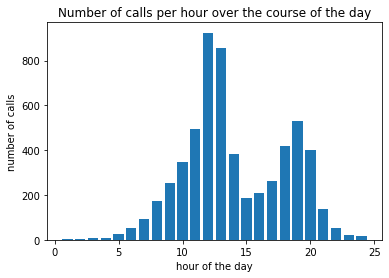

In [4]:
# Plot the number of calls per hour as a bar plot
calls_per_hour = [len(hour) for hour in waiting_times_per_hour]
plt.bar(range(1,25),calls_per_hour)
plt.xlabel('hour of the day')
plt.ylabel('number of calls')
plt.title('Number of calls per hour over the course of the day')
plt.show()

## Focus on a sample hour-hour 9

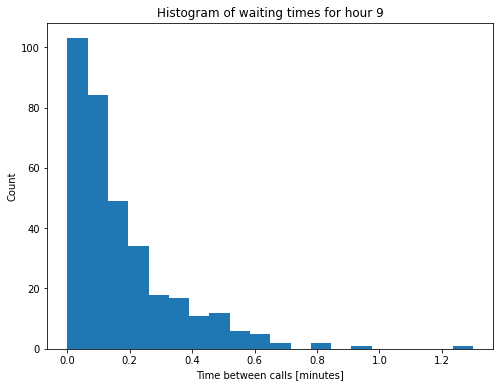

In [5]:
# Plot histogram of waiting times for one hour
hour_index = 9
waiting_times_hour = waiting_times_per_hour[hour_index]

plt.figure(figsize=(8, 6))
plt.hist(waiting_times_hour, bins=20)
plt.xlabel('Time between calls [minutes]')
plt.ylabel('Count')
plt.title(f'Histogram of waiting times for hour {hour_index}')
plt.show()

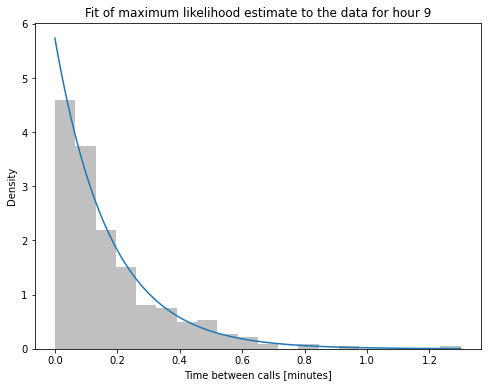

In [6]:
# Exponential distribution with maximum likelihood fit to the data
lambda_ = 1 / np.mean(waiting_times_hour)
distribution = sts.expon(scale=1/lambda_)

plt.figure(figsize=(8, 6))
plt.hist(waiting_times_hour, bins=20, density=True, color='#c0c0c0')
x = np.linspace(0, max(waiting_times_hour), 200)
y = distribution.pdf(x)
plt.plot(x, y)
plt.xlabel('Time between calls [minutes]')
plt.ylabel('Density')
plt.title(f'Fit of maximum likelihood estimate to the data for hour {hour_index}')
plt.show()

## Bayesian Inference on Hour 9?

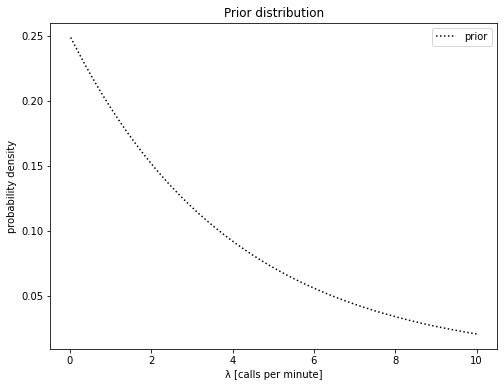

In [7]:
# DEFINE THE PRIOR DISTRIBUTION

# This function takes 1 input, namely the parameter value (λ) at which to
# compute the prior probability density. You need to evaluate the distribution
# Gamma(λ | α, β).

def prior(lambd):
    # Gamma distribution
    distribution = sts.gamma(a=1, scale=1/0.25)
    return distribution.pdf(lambd)

# PLOT THE PRIOR

lambdas = np.linspace(0, 10, 500)[1:]

plt.figure(figsize=(8, 6))
plt.plot(lambdas, prior(lambdas), color='black', linestyle=':', label='prior')
plt.xlabel('λ [calls per minute]')
plt.ylabel('probability density')
plt.title(f'Prior distribution')
plt.legend()
plt.show()

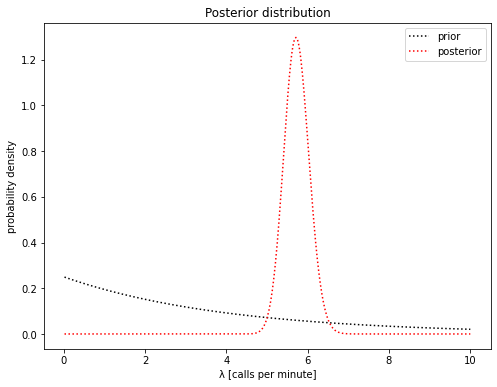

In [8]:
# DEFINE THE LIKELIHOOD FUNCTION
#
# This function takes 2 inputs, namely the parameter (λ) value at which to
# compute the likelihood and a value from the data set. You need to evaluate
# the exponential distribution of the datum given the parameter value.

def likelihood(lambda_, datum):
    return sts.expon.pdf(datum, scale=1/lambda_)
    # return sts.expon(scale=1/lambda_).pdf(datum)

# THE POSTERIOR DISTRIBUTION
# (COMPUTED AUTOMATICALLY USING THE PRIOR AND LIKELIHOOD)
#
# The function below is provided to help make computing the posterior easier. It
# follows the same pattern as in the previous class, where we multiple the prior
# and the likelihood evaluated at various values of the parameter (λ).
#
# You will see the function uses the logarithms of various distributions. This
# is for numerical reasons. When you multiply lots of likelihood values, the
# result can become very large or very small, causing numerical overflow or
# underflow in Python. Taking logarithms avoids this problem.

def compute_posterior(parameter_values, prior, likelihood, data):
    log_prior = np.log(prior(parameter_values))
    log_likelihood = np.array([
        np.sum(np.log(likelihood(param, data)))
        for param in parameter_values])
    unnormalized_log_posterior = log_prior + log_likelihood
    unnormalized_log_posterior -= max(unnormalized_log_posterior)
    unnormalized_posterior = np.exp(unnormalized_log_posterior)
    area = sp.integrate.trapz(unnormalized_posterior, parameter_values)
    posterior = unnormalized_posterior / area
    return posterior

posterior = compute_posterior(lambdas, prior, likelihood, waiting_times_hour)

# YOU NEED TO PLOT THE PRIOR AND POSTERIOR ON THE SAME AXES.
plt.figure(figsize=(8, 6))
plt.plot(lambdas, prior(lambdas), color='black', linestyle=':', label='prior')
plt.plot(lambdas, posterior, color='red', linestyle=':', label='posterior')
plt.xlabel('λ [calls per minute]')
plt.ylabel('probability density')
plt.title(f'Posterior distribution')
plt.legend()
plt.show()

In [9]:
def compute_percentile(parameter_values, distribution_values, percentile):
    '''
    Compute the parameter value at a particular percentile of the given
    probability distribution values. This function uses the cumulative trapezoid
    integrator in SciPy.

    Inputs:

        parameter_values (array of float) This is the list of parameter values
          at which the probability distribution has been evaluated.

        distribution_values (array of float) This is the list of values of the
          probability density function evaluated at the parameter values above.

        percentile (float) This is the value between 0 and 1 of the percentile
          to compute.

    Returns: (float) The parameter value at the given percentile.
    '''
    cumulative_distribution = sp.integrate.cumtrapz(
        distribution_values, parameter_values)
    percentile_index = np.searchsorted(cumulative_distribution, percentile)
    return lambdas[percentile_index]

# YOU HAVE TO USE THE FUNCTION ABOVE TO COMPUTE THE CONFIDENCE INTERVAL
print("95% confidence interval from",compute_percentile(lambdas, posterior, 0.025),
      "to",compute_percentile(lambdas, posterior, 0.975))

95% confidence interval from 5.130260521042084 to 6.332665330661323


## Bayesian inference for every hour
For the other 23hr, we assume the data is the same, so we can reuse all the functions, simply switching the data out for each of the hours.

In [10]:
# Define empty lists to fill with the 24 values for lower and upper bounds of the 98% confidence interval
# as well as the means
confidence_intervals = []
means = []
for hour in waiting_times_per_hour:
    # compute the new posterior with the same prior and likelihood depending on the new data
    posterior = compute_posterior(lambdas, prior, likelihood, hour)
    # lower bound is the 0.01 percentile, upper bound the 0.99 percentile
    confidence_intervals.append(
        [compute_percentile(lambdas, posterior, 0.01),compute_percentile(lambdas, posterior, 0.99)])
    # the mean is the dot product of lambdas and the posterior divided by the sum of the posterior
    means.append(np.dot(posterior,lambdas)/np.sum(posterior))

In [11]:
# get just the lower and upper bounds of the 98% confidence intervals
lower = np.array(confidence_intervals)[:,0]
upper = np.array(confidence_intervals)[:,1]

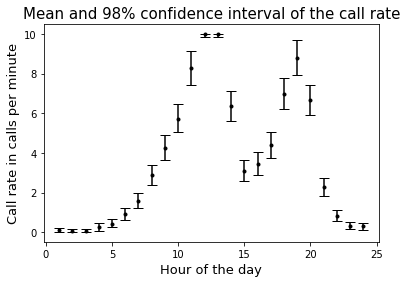

In [12]:
# Plot the means and their confidence intervals over time
plt.errorbar(range(1,25),means,yerr=np.array([means-lower,upper-means]),fmt='.k',capsize=5)
plt.title("Mean and 98% confidence interval of the call rate",size=15)
plt.ylabel("Call rate in calls per minute",size=13)
plt.xlabel("Hour of the day",size=13)
plt.show()

## Stretch Goal-Compute_posterior
Create an example where not taking logarithms would cause a problem. Create a prior,
likelihood, and data set that fails to produce the correct posterior when we don’t take logs.
Show all your code and visualize your results on one or more plots.

In [13]:
def compute_non_log_posterior(parameter_values, prior, likelihood, data):
    prior_f = prior(parameter_values)
    likelihood_f = np.prod(np.array([np.array(likelihood(param, data))
        for param in parameter_values]),1)
    unnormalized_posterior = prior_f*likelihood_f
    unnormalized_posterior = unnormalized_posterior/max(unnormalized_posterior)
    area = sp.integrate.trapz(unnormalized_posterior, parameter_values)
    posterior = unnormalized_posterior/area
    return posterior

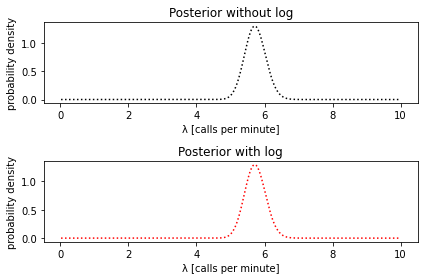

In [14]:
# use all the original data and distributions and compare the two compute_posterior functions
posterior = compute_posterior(lambdas, prior, likelihood, waiting_times_hour)
posterior_2 = compute_non_log_posterior(lambdas, prior, likelihood, waiting_times_hour)

# plot the two posterior distributions. 
# They are identical
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(lambdas,posterior_2, color='black', linestyle=':')
ax1.set_title('Posterior without log')
ax2.plot(lambdas, posterior, color='red', linestyle=':')
ax2.set_title('Posterior with log')
ax1.set(xlabel='λ [calls per minute]',ylabel= 'probability density')
ax2.set(xlabel='λ [calls per minute]',ylabel= 'probability density')
fig.tight_layout()
plt.show()

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


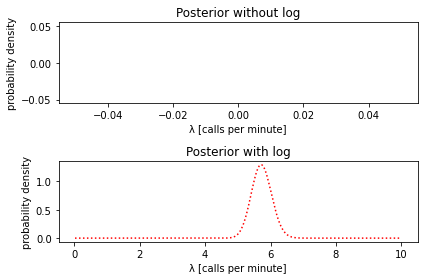

In [15]:
# define a new likelihood function that multiplies the original by a large integer
def broken_likelihood(lambda_, datum):
    return 9999999999999*sts.expon.pdf(datum, scale=1/lambda_)

# compute the posterior with the two methods and the broken likelihood function
log_posterior = compute_posterior(lambdas, prior, broken_likelihood, waiting_times_hour)
wrong_posterior = compute_non_log_posterior(lambdas, prior, broken_likelihood, waiting_times_hour)

# plot the two results (one of them was not able to be computed)
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(lambdas,wrong_posterior, color='black', linestyle=':')
ax1.set_title('Posterior without log')
ax2.plot(lambdas, log_posterior, color='red', linestyle=':')
ax2.set_title('Posterior with log')
ax1.set(xlabel='λ [calls per minute]',ylabel= 'probability density')
ax2.set(xlabel='λ [calls per minute]',ylabel= 'probability density')
fig.tight_layout()
plt.show()